[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/asteroid-team/asteroid/blob/master/notebooks/00_GettingStarted.ipynb)

## About Asteroid

Asteroid is an open-source, community-based toolkit made to design, train, evaluate, use and share audio source separation models such as Deep clustering ([Hershey et al.](https://arxiv.org/abs/1508.04306)), ConvTasNet ([Luo et al.](https://arxiv.org/abs/1809.07454)) DPRNN ([Luo et al.](https://arxiv.org/abs/1910.06379)) etc...

## About this tutorial

In this tutorial you will learn to:

- Perform speech separation inference using a pretrained model.
- Run a very simple training on a tiny dataset.

Training models on a larger dataset/your own data and writing your own models will be explained in another tutorial.

## Install Asteroid

Install Asteroid to get started:

In [1]:
#%%capture
#!pip install -U git+https://github.com/asteroid-team/asteroid

## Pretrained model speech separation

Asteroid comes with [pretrained models](https://zenodo.org/communities/asteroid-models) that help you get started quickly, like the 8 kHz [DPRRN](https://zenodo.org/record/3903795).

As an example audio file to separate, you can use a mixture from the Deep clustering paper. Let's download it and listen to the unseparated version:

In [2]:
%%capture
!wget https://www.merl.com/demos/deep-clustering/media/female-female-mixture.wav

In [1]:
from IPython.display import display, Audio

%load_ext autoreload
%autoreload 2

display(Audio("female-female-mixture.wav"))

### Separate using the `asteroid-infer` CLI

The `asteroid-infer` command will download a model from Zenodo and run separation on each of the files given, creating 2 estimated sources `_est1.wav` and `_est2.wav`:

In [4]:
!asteroid-infer "mpariente/DPRNNTasNet(ks=16)_WHAM!_sepclean" --files female-female-mixture.wav
!echo "-----"
!ls

100%|██████████████████████████████████████| 14.0M/14.0M [00:00<00:00, 16.5MB/s]
-----
00_GettingStarted.ipynb		 female-female-mixture_est1.wav
01_APIOverview.ipynb		 female-female-mixture_est2.wav
02_Filterbank.ipynb		 female-female-mixture.wav
03_PITLossWrapper.ipynb		 README.md
04_ProcessLargeAudioFiles.ipynb


In [5]:
display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

### Separate in Python

You can also run separation using Python code.

In [2]:
from asteroid import DPRNNTasNet
import librosa

model = DPRNNTasNet.from_pretrained("mpariente/DPRNNTasNet(ks=16)_WHAM!_sepclean")

# You can pass a NumPy array:
mixture, _ = librosa.load("female-female-mixture.wav", sr=8000)
model.separate(mixture)

# Or simply a file name:
model.separate("female-female-mixture.wav")

Using cached model `mpariente/DPRNNTasNet(ks=16)_WHAM!_sepclean`


/homes/dm005/projects/asteroid/asteroid/separate.py:160: UserWarning: File female-female-mixture_est1.wav already exists, pass `force_overwrite=True` to overwrite it
  warnings.warn(


### Visualize the results

You can visualize the separation results as magnitude spectrograms:

/homes/dm005/conda_env/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/homes/dm005/conda_env/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/homes/dm005/conda_env/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


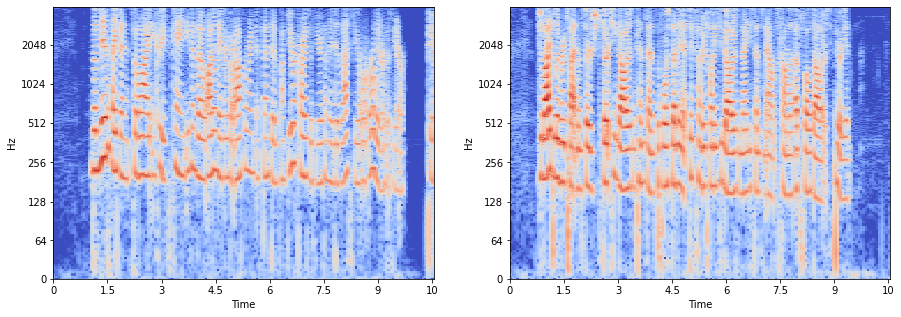

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


def show_magspec(waveform, **kw):
    return librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(librosa.stft(waveform))),
        y_axis="log", x_axis="time",
        **kw
    )


est1, _ = librosa.load("female-female-mixture_est1.wav", sr=8000)
est2, _ = librosa.load("female-female-mixture_est2.wav", sr=8000)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
show_magspec(est1, sr=8000, ax=ax[0])
show_magspec(est2, sr=8000, ax=ax[1])

## Train your own model

Asteroid makes it easy to train your own models. In this tutorial you will learn the absolute minimum required to perform a simplistic training on a tiny dataset. Training a high-quality model is more involved and will be explained in another tutorial.

Run the code below to perform the training. It should take around 1 minute per epoch on Google Colab.

While the training runs, read through the code comments below!

In [1]:
# Asteroid is based on PyTorch and PyTorch-Lightning.
from torch import optim
from pytorch_lightning import Trainer

# We train the same model architecture that we used for inference above.
from asteroid import DPRNNTasNet

# In this example we use Permutation Invariant Training (PIT) and the SI-SDR loss.
from asteroid.losses import pairwise_neg_sisdr, PITLossWrapper

# MiniLibriMix is a tiny version of LibriMix (https://github.com/JorisCos/LibriMix),
# which is a free speech separation dataset.
from asteroid.data import LibriMix

# Asteroid's System is a convenience wrapper for PyTorch-Lightning.
from asteroid.engine import System

# This will automatically download MiniLibriMix from Zenodo on the first run.
train_loader, val_loader = LibriMix.loaders_from_mini(task="sep_clean", batch_size=8)

# Tell DPRNN that we want to separate to 2 sources.
model = DPRNNTasNet(n_src=2)

# PITLossWrapper works with any loss function.
loss = PITLossWrapper(pairwise_neg_sisdr, pit_from="pw_mtx")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

system = System(model, optimizer, loss, train_loader, val_loader)

# Train for 1 epoch using a single GPU. If you're running this on Google Colab,
# be sure to select a GPU runtime (Runtime → Change runtime type → Hardware accelarator).
trainer = Trainer(max_epochs=1, gpus=1)
trainer.fit(system)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)



  | Name      | Type           | Params
---------------------------------------------
0 | model     | DPRNNTasNet    | 3.7 M 
1 | loss_func | PITLossWrapper | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: `training_step` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)


1

# Again, you can use ``separate()`` to run inference:

In [8]:
model.separate("female-female-mixture.wav", force_overwrite=True)

In [9]:
from IPython.display import display, Audio

display(Audio("female-female-mixture_est1.wav"))
display(Audio("female-female-mixture_est2.wav"))

As you can hear, the model performance is really bad. That's because MiniLibriMix is far too small for training, and because we didn't train for long enough. For a real training, you need at least 10x–100x the amount of data, and have to train for a lot longer. 

## Further reading

That's it for this tutorial.

You can find more info about Asteroid on the [Asteroid website](https://asteroid-team.github.io/) and in the [Asteroid paper](https://arxiv.org/abs/2005.04132) ([presentation](https://www.youtube.com/watch?v=imnZxQwuNcg)\).